# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
# importing all packages
import numpy as np
import os
from scipy.misc import imread, imresize
from skimage import transform,io
import datetime
import os
from skimage.transform import resize
# We set the Random seed so that results does not vary drastically
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)
import abc
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')


Using TensorFlow backend.


### Data Preparation
- Checking the size of images

In [2]:
##Check the shape of images
source_path='Project_data'
train_file=source_path+"/train.csv"

with open(train_file) as f:
    lines = f.readlines()
    
# set of the images size
s = set()

# For all images in the training set, find the shape and add it to the set. The set will hence contain all the different image sizes.
for l in lines:
    folder=source_path + "/train"+"/" + l.split(';')[0]
    imgs = os.listdir(folder)
    for i in imgs:
        img_name=folder + "/" + i
        image = io.imread(img_name)
        s.add(image.shape)



In [3]:
# dimensions of images
print(s)

{(360, 360, 3), (120, 160, 3)}


(360, 360, 3)


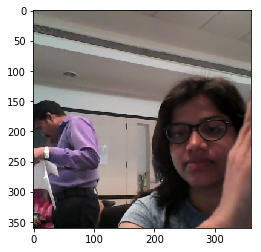

In [4]:
# initializing the image
img_name = 'Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png'
image = io.imread(img_name)
# The original size of the image
print(image.shape)
plt.imshow(image)
plt.show()

In [5]:
# resizing the image using imresize
resized = imresize(image, (120,120))
# size of the image after resize
print(resized.shape)


(120, 120, 3)


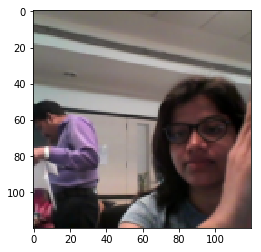

In [6]:
#plot the resized image
plt.imshow(resized)
plt.show()


In [7]:
print(resized[:, : , 0]/255)

[[0.46666667 0.47058824 0.4627451  ... 0.54509804 0.5372549  0.52941176]
 [0.47843137 0.4745098  0.47058824 ... 0.5372549  0.52941176 0.5254902 ]
 [0.51372549 0.50980392 0.50980392 ... 0.53333333 0.5254902  0.52156863]
 ...
 [0.46666667 0.32941176 0.27058824 ... 0.25098039 0.27843137 0.29019608]
 [0.29019608 0.16078431 0.19607843 ... 0.25490196 0.29019608 0.29411765]
 [0.14117647 0.08627451 0.1254902  ... 0.2627451  0.28627451 0.28627451]]


#### Image Pre-Processing

In [8]:
#defining function for preprocess
def pre_process_image(img, x=120, y=120):
#     img2 = img
    img2 = crop_from_center(img)
    img2 = imresize(img2,(x,y,3))
    # now normalize the image
    img2 = img2.astype("float") / 255.0
    return img2

#defining function for cropping the images
def crop_from_center(img):
    y, x, c = img.shape
   
    if y > x:
        ref = x
    elif x > y:
        ref = y
    elif x == y:
        ref = y
   
    cropx = cropy = ref

    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty + cropy, startx:startx + cropx, : ]

In [9]:
# loading project folder
Project_folder = 'Project_data'

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [10]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def init_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def init_image(self,image_h=100,image_w=100):
        self.image_h=image_h
        self.image_w=image_w
        self.channels=3
        self.total_frames=30
        self.num_classes=5
        
          
    def init_hyperparams(self,frame_sample=30,batch_size=20,num_epochs=20):
        self.frame_sample=frame_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frame_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_h,self.image_w,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_h,self.image_w,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #resized=imresize(image,(self.image_h,self.image_w,3))
                image = pre_process_image(image, self.image_h,self.image_w )

                batch_data[folder,idx,:,:,0] = image[:,:,0] #(resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = image[:,:,1] #(resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = image[:,:,2] #(resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    crop=shifted[x0:x1,y0:y1,:]
                    
                    #resized=imresize(crop,(self.image_h,self.image_w,3))
                    crop = pre_process_image(image, self.image_h,self.image_w )
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = pre_process_image(image[:,:,0])#(resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = pre_process_image(image[:,:,1])#(resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = pre_process_image(image[:,:,2])#(resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

#### Plot Curve

In [11]:
## Plotting Curve 
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [12]:
### Importing all packages for model deployment
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

#### Model 1
- with sample_size=30, filter=(3,3,3), layers=(16,32,64,128)

In [24]:
class Conv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(self.frame_sample,self.image_h,self.image_w,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'optimizers.SGD'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
# Initialize paths 
conv3d1=Conv3D1()
conv3d1.init_path(Project_folder)
conv3d1.init_image(image_h=120,image_w=120)
conv3d1.init_hyperparams(frame_sample=30,batch_size=40,num_epochs=20)
conv3d1_model=conv3d1.define_model()
conv3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_14 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 15, 60, 60, 32)    128       
__________

In [26]:
## Train the model
print("Total Params:", conv3d1_model.count_params())
history1 = conv3d1.train_model(conv3d1_model)


Total Params: 900805
Epoch 1/20
17/17 [==============================] - 89s 5s/step - loss: 1.6393 - categorical_accuracy: 0.3898 - val_loss: 1.8269 - val_categorical_accuracy: 0.4400

Epoch 00001: val_loss improved from inf to 1.82692, saving model to model_init_2020-03-2813_42_25.822997/model-00001-1.64327-0.38763-1.82692-0.44000.h5
Epoch 2/20
17/17 [==============================] - 76s 4s/step - loss: 1.0322 - categorical_accuracy: 0.5942 - val_loss: 1.2090 - val_categorical_accuracy: 0.5700

Epoch 00002: val_loss improved from 1.82692 to 1.20898, saving model to model_init_2020-03-2813_42_25.822997/model-00002-1.03568-0.59276-1.20898-0.57000.h5
Epoch 3/20
17/17 [==============================] - 78s 5s/step - loss: 0.8107 - categorical_accuracy: 0.6889 - val_loss: 0.9125 - val_categorical_accuracy: 0.6800

Epoch 00003: val_loss improved from 1.20898 to 0.91248, saving model to model_init_2020-03-2813_42_25.822997/model-00003-0.80470-0.69080-0.91248-0.68000.h5
Epoch 4/20
17/17 [==

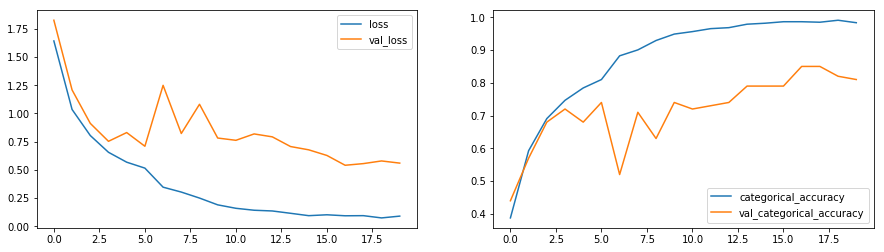

In [35]:
plot(history1)

#### Model 2
- with sample_size=20, filter=(3,3,3), batch=40, Epochs= 20, layers= (16,32,64,128), dense=64

In [36]:
class conv3D2(ModelBuilder): 
    def define_model(self,filtersize=(3,3,3),dense=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',input_shape=(self.frame_sample,self.image_h,self.image_w,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [37]:
conv3d2=conv3D2()
conv3d2.init_path(Project_folder)
conv3d2.init_image(image_h=120,image_w=120) 
conv3d2.init_hyperparams(frame_sample=20,batch_size=40,num_epochs=20)#previous 15
conv3d2_model=conv3d2.define_model()
conv3d2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_21 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_22 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 10, 60, 60, 32)    128       
__________

In [38]:
print("Total Params:", conv3d2_model.count_params())
history2 = conv3d2.train_model(conv3d2_model)


Total Params: 699269
Epoch 1/20
17/17 [==============================] - 63s 4s/step - loss: 1.6966 - categorical_accuracy: 0.3730 - val_loss: 2.3049 - val_categorical_accuracy: 0.3100

Epoch 00001: val_loss improved from inf to 2.30491, saving model to model_init_2020-03-2815_22_57.530228/model-00001-1.70538-0.37255-2.30491-0.31000.h5
Epoch 2/20
17/17 [==============================] - 43s 3s/step - loss: 1.2357 - categorical_accuracy: 0.5176 - val_loss: 1.6376 - val_categorical_accuracy: 0.4500

Epoch 00002: val_loss improved from 2.30491 to 1.63759, saving model to model_init_2020-03-2815_22_57.530228/model-00002-1.23771-0.51433-1.63759-0.45000.h5
Epoch 3/20
17/17 [==============================] - 52s 3s/step - loss: 0.9415 - categorical_accuracy: 0.6437 - val_loss: 0.8952 - val_categorical_accuracy: 0.6400

Epoch 00003: val_loss improved from 1.63759 to 0.89525, saving model to model_init_2020-03-2815_22_57.530228/model-00003-0.93850-0.64555-0.89525-0.64000.h5
Epoch 4/20
17/17 [==

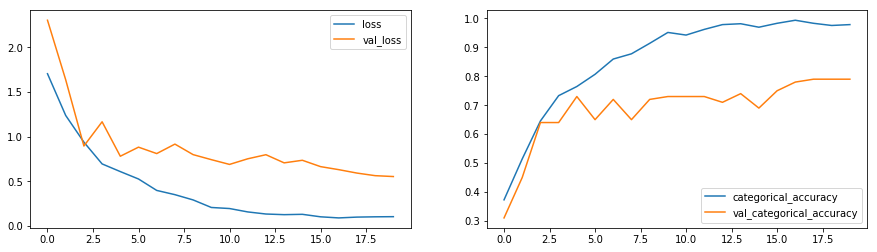

In [39]:
plot(history2)

#### Model 3
- Previous model with increase in dense=256 and dropout = 0.25, samplesize=20, batch=20, Epochs=25

In [40]:
#changing batch_size and epochs for previous model
conv_3d2= conv3D2()
conv_3d2.init_path(Project_folder)
conv_3d2.init_image(image_h=120,image_w=120)
conv_3d2.init_hyperparams(frame_sample=20,batch_size=20,num_epochs=25)
conv3d2_model=conv_3d2.define_model(dense=256,dropout=0.5) #increased dense
conv3d2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_25 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_26 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 10, 60, 60, 32)    128       
__________

In [41]:
print("Total Params:", conv3d2_model.count_params())
history3 = conv3d2.train_model(conv3d2_model)


Total Params: 1967813
Epoch 1/20
17/17 [==============================] - 59s 3s/step - loss: 2.0502 - categorical_accuracy: 0.3783 - val_loss: 2.4514 - val_categorical_accuracy: 0.4600

Epoch 00001: val_loss improved from inf to 2.45144, saving model to model_init_2020-03-2815_49_28.982673/model-00001-2.04488-0.38009-2.45144-0.46000.h5
Epoch 2/20
17/17 [==============================] - 45s 3s/step - loss: 1.4049 - categorical_accuracy: 0.5169 - val_loss: 2.3555 - val_categorical_accuracy: 0.4400

Epoch 00002: val_loss improved from 2.45144 to 2.35551, saving model to model_init_2020-03-2815_49_28.982673/model-00002-1.40727-0.51885-2.35551-0.44000.h5
Epoch 3/20
17/17 [==============================] - 51s 3s/step - loss: 1.2488 - categorical_accuracy: 0.5797 - val_loss: 1.5867 - val_categorical_accuracy: 0.6000

Epoch 00003: val_loss improved from 2.35551 to 1.58667, saving model to model_init_2020-03-2815_49_28.982673/model-00003-1.24125-0.58220-1.58667-0.60000.h5
Epoch 4/20
17/17 [=

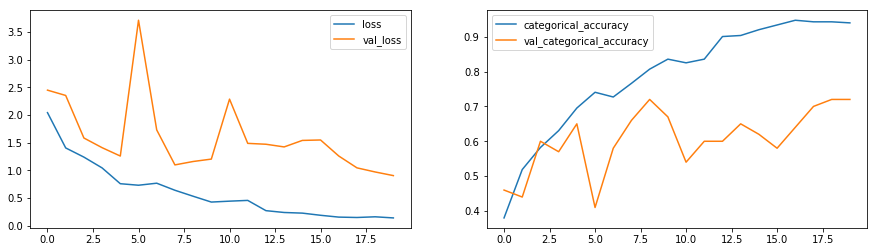

In [42]:
plot(history3)

#### Model 4
- with sample_size=16, filter=(2,2,2), dense=256, layer=(16,32,64,128), batch=30, Epochs=30

In [43]:
class conv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(2,2,2),dense=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',input_shape=(self.frame_sample,self.image_h,self.image_w,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [44]:
conv_3d4= conv3D4()
conv_3d4.init_path(Project_folder)
conv_3d4.init_image(image_h=120,image_w=120)
conv_3d4.init_hyperparams(frame_sample=16,batch_size=30,num_epochs=30)
conv3d4_model=conv_3d4.define_model(dense=256,dropout=0.5) #increased dense
conv3d4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_29 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_30 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 8, 60, 60, 32)     128       
__________

In [49]:
print("Total Params:", conv3d4_model.count_params())
history4 = conv_3d4.train_model(conv3d4_model)


Total Params: 1762613
Epoch 1/30
23/23 [==============================] - 47s 2s/step - loss: 1.9400 - categorical_accuracy: 0.4045 - val_loss: 1.8582 - val_categorical_accuracy: 0.4800

Epoch 00001: val_loss improved from inf to 1.85820, saving model to model_init_2020-03-2816_35_23.533428/model-00001-1.88164-0.40724-1.85820-0.48000.h5
Epoch 2/30
23/23 [==============================] - 32s 1s/step - loss: 1.3452 - categorical_accuracy: 0.5183 - val_loss: 1.4308 - val_categorical_accuracy: 0.5700

Epoch 00002: val_loss improved from 1.85820 to 1.43084, saving model to model_init_2020-03-2816_35_23.533428/model-00002-1.28027-0.53846-1.43084-0.57000.h5
Epoch 3/30
23/23 [==============================] - 41s 2s/step - loss: 0.8990 - categorical_accuracy: 0.6763 - val_loss: 0.8281 - val_categorical_accuracy: 0.7300

Epoch 00003: val_loss improved from 1.43084 to 0.82807, saving model to model_init_2020-03-2816_35_23.533428/model-00003-0.92760-0.66365-0.82807-0.73000.h5
Epoch 4/30
23/23 [=

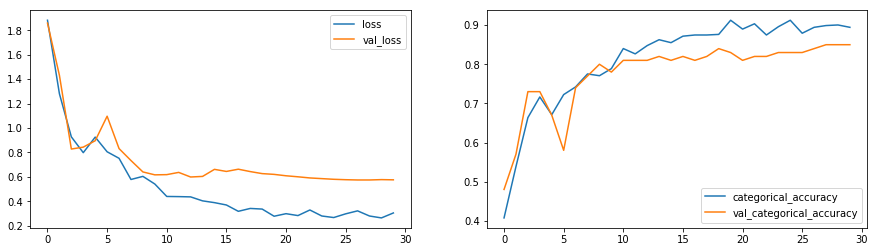

In [50]:
plot(history4)

#### Model 5
- adding more layer with augmentation

In [51]:
class conv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',input_shape=(self.frame_sample,self.image_h,self.image_w,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',input_shape=(self.frame_sample,self.image_h,self.image_w,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#         model.add(Conv3D(128, filtersize, padding='same'))
#         model.add(Activation('relu'))
#         model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [52]:
conv_3d5= conv3D5()
conv_3d5.init_path(Project_folder)
conv_3d5.init_image(image_h=120,image_w=120)
conv_3d5.init_hyperparams(frame_sample=20,batch_size=20,num_epochs=30)#change 16 to 20
conv3d5_model=conv_3d5.define_model(dense=256,dropout=0.5) #increased dense
conv3d5_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 20, 120, 120, 16)  6928      
_________________________________________________________________
activation_34 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 10, 60, 60, 16)    0         
__________

In [54]:
print("Total Params:", conv3d5_model.count_params())
history5 = conv_3d5.train_model(conv3d5_model, augment_data=False)


Total Params: 2113525
Epoch 1/30
34/34 [==============================] - 79s 2s/step - loss: 1.8453 - categorical_accuracy: 0.3812 - val_loss: 12.0764 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 12.07641, saving model to model_init_2020-03-2817_01_42.186069/model-00001-1.87120-0.37406-12.07641-0.23000.h5
Epoch 2/30
34/34 [==============================] - 64s 2s/step - loss: 1.5025 - categorical_accuracy: 0.5040 - val_loss: 6.2600 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss improved from 12.07641 to 6.25997, saving model to model_init_2020-03-2817_01_42.186069/model-00002-1.45908-0.50830-6.25997-0.22000.h5
Epoch 3/30
34/34 [==============================] - 64s 2s/step - loss: 1.2259 - categorical_accuracy: 0.5835 - val_loss: 1.2094 - val_categorical_accuracy: 0.5700

Epoch 00003: val_loss improved from 6.25997 to 1.20937, saving model to model_init_2020-03-2817_01_42.186069/model-00003-1.25194-0.57315-1.20937-0.57000.h5
Epoch 4/30
34/3

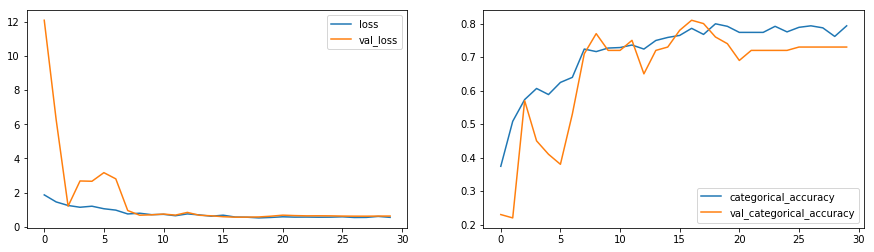

In [55]:
plot(history5)

#### Model 6
- previous model with more layer with without augmentation

In [60]:
conv_3d6= conv3D5()
conv_3d6.init_path(Project_folder)
conv_3d6.init_image(image_h=120,image_w=120)
conv_3d6.init_hyperparams(frame_sample=20,batch_size=20,num_epochs=30)#change 16 to 20
conv3d6_model=conv_3d6.define_model(dense=256,dropout=0.5) #increased dense
conv3d6_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_54 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_54 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_77 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
conv3d_55 (Conv3D)           (None, 20, 120, 120, 16)  6928      
_________________________________________________________________
activation_55 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_78 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 10, 60, 60, 16)    0         
__________

In [62]:
print("Total Params:", conv3d6_model.count_params())
history6 = conv_3d6.train_model(conv3d6_model)


Total Params: 2113525
Epoch 1/30
34/34 [==============================] - 77s 2s/step - loss: 2.0237 - categorical_accuracy: 0.3370 - val_loss: 11.2344 - val_categorical_accuracy: 0.2400

Epoch 00001: val_loss improved from inf to 11.23444, saving model to model_init_2020-03-2818_01_41.154996/model-00001-1.95923-0.34540-11.23444-0.24000.h5
Epoch 2/30
34/34 [==============================] - 64s 2s/step - loss: 1.6304 - categorical_accuracy: 0.4290 - val_loss: 7.7708 - val_categorical_accuracy: 0.2600

Epoch 00002: val_loss improved from 11.23444 to 7.77081, saving model to model_init_2020-03-2818_01_41.154996/model-00002-1.63990-0.43137-7.77081-0.26000.h5
Epoch 3/30
34/34 [==============================] - 64s 2s/step - loss: 1.5439 - categorical_accuracy: 0.4643 - val_loss: 12.0538 - val_categorical_accuracy: 0.2300

Epoch 00003: val_loss did not improve from 7.77081
Epoch 4/30
34/34 [==============================] - 64s 2s/step - loss: 1.4856 - categorical_accuracy: 0.4849 - val_los

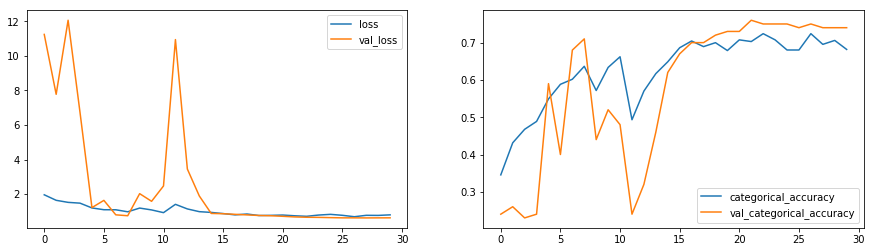

In [63]:
plot(history6)

#### Model 7
- Reducing the layers

In [31]:
class conv3D7(ModelBuilder):
    
    def define_model(self,dense=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(self.frame_sample,self.image_h,self.image_w,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [32]:
conv_3d7=conv3D7()
conv_3d7.init_path(Project_folder)
conv_3d7.init_image(image_h=120,image_w=120)
conv_3d7.init_hyperparams(frame_sample=20,batch_size=20,num_epochs=30)
conv3d7_model=conv_3d7.define_model(dense=128,dropout=0.25)
conv3d7_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_17 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_18 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 10, 60, 60, 32)    128       
__________

In [33]:
print("Total Params:", conv3d7_model.count_params())
history7 = conv_3d7.train_model(conv3d7_model)


Total Params: 909637
Epoch 1/30
34/34 [==============================] - 57s 2s/step - loss: 1.4985 - categorical_accuracy: 0.4481 - val_loss: 1.8732 - val_categorical_accuracy: 0.4200

Epoch 00001: val_loss improved from inf to 1.87320, saving model to model_init_2020-03-2814_49_56.190206/model-00001-1.50012-0.45098-1.87320-0.42000.h5
Epoch 2/30
34/34 [==============================] - 44s 1s/step - loss: 0.9456 - categorical_accuracy: 0.6387 - val_loss: 0.9291 - val_categorical_accuracy: 0.6900

Epoch 00002: val_loss improved from 1.87320 to 0.92911, saving model to model_init_2020-03-2814_49_56.190206/model-00002-0.93147-0.63801-0.92911-0.69000.h5
Epoch 3/30
34/34 [==============================] - 52s 2s/step - loss: 0.7972 - categorical_accuracy: 0.6851 - val_loss: 1.3118 - val_categorical_accuracy: 0.5400

Epoch 00003: val_loss did not improve from 0.92911
Epoch 4/30
34/34 [==============================] - 51s 1s/step - loss: 0.7219 - categorical_accuracy: 0.7174 - val_loss: 0.8

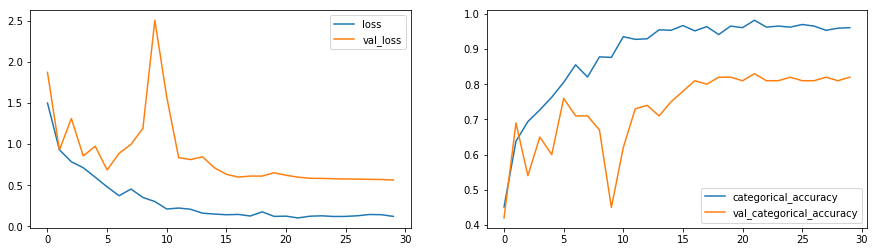

In [34]:
plot(history7)

In [45]:
#### Model 8

In [13]:
class conv3D8(ModelBuilder):
    
    def define_model(self,dense=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',input_shape=(self.frame_sample,self.image_h,self.image_w,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
conv_3d8=conv3D8()
conv_3d8.init_path(Project_folder)
conv_3d8.init_image(image_h=120,image_w=120)
conv_3d8.init_hyperparams(frame_sample=20,batch_size=20,num_epochs=30)
conv3d8_model=conv_3d8.define_model(dense=64,dropout=0.25)#reduced to 64
conv3d8_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 120, 120, 8)   656       
_________________________________________________________________
activation_1 (Activation)    (None, 20, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 60, 60, 16)    1040      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 60, 60, 16)    64        
__________

In [16]:
print("Total Params:", conv3d8_model.count_params())
history8 = conv_3d8.train_model(conv3d8_model)


Total Params: 228517
Epoch 1/30
34/34 [==============================] - 72s 2s/step - loss: 1.6044 - categorical_accuracy: 0.3907 - val_loss: 1.3679 - val_categorical_accuracy: 0.5900

Epoch 00001: val_loss improved from inf to 1.36786, saving model to model_init_2020-03-2819_25_00.131040/model-00001-1.61791-0.39216-1.36786-0.59000.h5
Epoch 2/30
34/34 [==============================] - 48s 1s/step - loss: 0.9738 - categorical_accuracy: 0.6078 - val_loss: 0.9755 - val_categorical_accuracy: 0.5800

Epoch 00002: val_loss improved from 1.36786 to 0.97551, saving model to model_init_2020-03-2819_25_00.131040/model-00002-0.94960-0.62293-0.97551-0.58000.h5
Epoch 3/30
34/34 [==============================] - 48s 1s/step - loss: 0.7287 - categorical_accuracy: 0.7152 - val_loss: 1.5378 - val_categorical_accuracy: 0.5700

Epoch 00003: val_loss did not improve from 0.97551
Epoch 4/30
34/34 [==============================] - 49s 1s/step - loss: 0.6480 - categorical_accuracy: 0.7506 - val_loss: 1.0

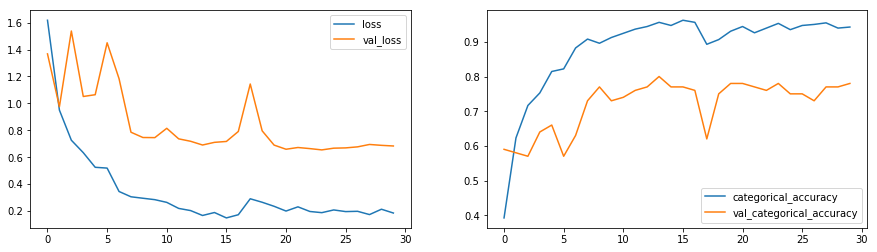

In [17]:
plot(history8)

In [50]:
#### Model 9 Conv2d+CNN

In [18]:
class conv2dwithgru(ModelBuilder):
    
    def define_model(self, dense=64, dropout=0.25):
        cnn_model = Sequential()
        cnn_model.add(TimeDistributed(Conv2D(8, (1, 1), padding='same'), input_shape=(self.frame_sample,self.image_h,self.image_w,self.channels)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(8, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(dropout))
        
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        cnn_model.add(Dropout(dropout))
        
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))

        cnn_model.add(Dropout(dropout))
        
        cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))

        
        cnn_model.add(TimeDistributed(Flatten()))
#         cnn_model.add(Dense(dense))
#         cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dense(dense))
        cnn_model.add(Dropout(dropout))
        cnn_model.add(GRU(64, return_sequences=False))
#         cnn_model.add(Dense(32))
        cnn_model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = optimizers.Adam()
        cnn_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return cnn_model

In [20]:
# conv_2d=conv2dwithgru()
# conv_2d.init_path(Project_folder)
# conv_2d.init_image(image_h=120,image_w=120)
# conv_2d.init_hyperparams(frame_sample=20,batch_size=20,num_epochs=30)
# conv2d_model=conv_2d.define_model(dense=128,dropout=0.25)#reduced 
# conv2d_model.summary()

In [53]:
# print("Total Params:", conv2d_model.count_params())
# history9 = conv_2d.train_model(conv2d_model)


In [54]:
# plot(history9)

In [57]:
#### Model 10 Conv2d+CNN
#Reducing number of layers

In [21]:
class conv2dwithgru(ModelBuilder):
    
    def define_model(self, dense=64, dropout=0.25):
        cnn_model = Sequential()
        cnn_model.add(TimeDistributed(Conv2D(8, (1, 1), padding='same'), input_shape=(self.frame_sample,self.image_h,self.image_w,self.channels)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(dropout))
        
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        cnn_model.add(Dropout(dropout))
        
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))

#         cnn_model.add(Dropout(dropout))
        
#         cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same')))
#         cnn_model.add(TimeDistributed(Activation('relu')))

        
        cnn_model.add(TimeDistributed(Flatten()))
#         cnn_model.add(Dense(dense))
#         cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dense(dense))
        cnn_model.add(Dropout(dropout))
        cnn_model.add(GRU(64, return_sequences=False))
#         cnn_model.add(Dense(32))
        cnn_model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = optimizers.Adam()
        cnn_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return cnn_model

In [22]:
conv_2d=conv2dwithgru()
conv_2d.init_path(Project_folder)
conv_2d.init_image(image_h=120,image_w=120)
conv_2d.init_hyperparams(frame_sample=20,batch_size=20,num_epochs=30)
conv2d_model=conv_2d.define_model(dense=128,dropout=0.25)#reduced 
conv2d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_22 (TimeDis (None, 20, 120, 120, 8)   32        
_________________________________________________________________
time_distributed_23 (TimeDis (None, 20, 120, 120, 8)   0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 20, 40, 40, 8)     0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 20, 40, 40, 8)     32        
_________________________________________________________________
time_distributed_26 (TimeDis (None, 20, 40, 40, 16)    1168      
_________________________________________________________________
time_distributed_27 (TimeDis (None, 20, 40, 40, 16)    0         
_________________________________________________________________
time_distributed_28 (TimeDis (None, 20, 13, 13, 16)    0         
__________

In [23]:
print("Total Params:", conv2d_model.count_params())
history10 = conv_2d.train_model(conv2d_model)

Total Params: 400325
Epoch 1/30
34/34 [==============================] - 54s 2s/step - loss: 1.5866 - categorical_accuracy: 0.3407 - val_loss: 1.1735 - val_categorical_accuracy: 0.5400

Epoch 00001: val_loss improved from inf to 1.17346, saving model to model_init_2020-03-2819_53_38.138585/model-00001-1.58992-0.34087-1.17346-0.54000.h5
Epoch 2/30
34/34 [==============================] - 50s 1s/step - loss: 1.1259 - categorical_accuracy: 0.5276 - val_loss: 1.0386 - val_categorical_accuracy: 0.5500

Epoch 00002: val_loss improved from 1.17346 to 1.03865, saving model to model_init_2020-03-2819_53_38.138585/model-00002-1.14651-0.51584-1.03865-0.55000.h5
Epoch 3/30
34/34 [==============================] - 50s 1s/step - loss: 1.0045 - categorical_accuracy: 0.5953 - val_loss: 0.9844 - val_categorical_accuracy: 0.5900

Epoch 00003: val_loss improved from 1.03865 to 0.98444, saving model to model_init_2020-03-2819_53_38.138585/model-00003-0.99970-0.60181-0.98444-0.59000.h5
Epoch 4/30
34/34 [==

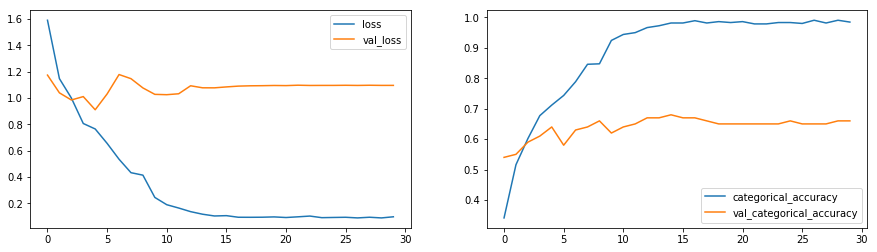

In [24]:
plot(history10)

In [63]:
#### Model 11 Cnv2d+LSTM

In [64]:
class conv2dwithLSTM(ModelBuilder):
    
    def define_model(self,lstm=64,dense=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(self.frame_sample,self.image_h,self.image_w,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# conv_2d=conv2dwithLSTM()
# conv_2d.init_path(Project_folder)
# conv_2d.init_image(image_h=120,image_w=120)
# conv_2d.init_hyperparams(frame_sample=20,batch_size=20,num_epochs=20)
# conv2d_model=conv_2d.define_model(dense=128,dropout=0.25)#change lstm=128 in next run 
# conv2d_model.summary()

In [66]:
# print("Total Params:", conv2d_model.count_params())
# history11 = conv_2d.train_model(conv2d_model)

In [ ]:
# plot(history11)

In [67]:
#### Model 11
# Reducing the no. of layers

In [25]:
class conv2dwithLSTM(ModelBuilder):
    
    def define_model(self,lstm=64,dense=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(self.frame_sample,self.image_h,self.image_w,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (2, 2) , padding='valid', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [26]:
conv_2d=conv2dwithLSTM()
conv_2d.init_path(Project_folder)
conv_2d.init_image(image_h=120,image_w=120)
conv_2d.init_hyperparams(frame_sample=20,batch_size=20,num_epochs=20)
conv2d_model=conv_2d.define_model(lstm=128,dense=128,dropout=0.25)#change lstm=128 in next run 
conv2d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_41 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_42 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_43 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, 20, 60, 60, 16)    2320      
_________________________________________________________________
time_distributed_45 (TimeDis (None, 20, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_46 (TimeDis (None, 20, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_47 (TimeDis (None, 20, 30, 30, 32)    4640      
__________

In [27]:
print("Total Params:", conv2d_model.count_params())
histor11 = conv_2d.train_model(conv2d_model)

Total Params: 401173
Epoch 1/20
34/34 [==============================] - 54s 2s/step - loss: 1.4657 - categorical_accuracy: 0.3606 - val_loss: 1.3003 - val_categorical_accuracy: 0.4600

Epoch 00001: val_loss improved from inf to 1.30035, saving model to model_init_2020-03-2820_18_56.899491/model-00001-1.45336-0.36953-1.30035-0.46000.h5
Epoch 2/20
34/34 [==============================] - 47s 1s/step - loss: 1.1367 - categorical_accuracy: 0.5335 - val_loss: 1.1864 - val_categorical_accuracy: 0.6000

Epoch 00002: val_loss improved from 1.30035 to 1.18639, saving model to model_init_2020-03-2820_18_56.899491/model-00002-1.13097-0.53846-1.18639-0.60000.h5
Epoch 3/20
34/34 [==============================] - 50s 1s/step - loss: 0.9614 - categorical_accuracy: 0.6174 - val_loss: 0.9494 - val_categorical_accuracy: 0.6100

Epoch 00003: val_loss improved from 1.18639 to 0.94940, saving model to model_init_2020-03-2820_18_56.899491/model-00003-0.97609-0.60784-0.94940-0.61000.h5
Epoch 4/20
34/34 [==

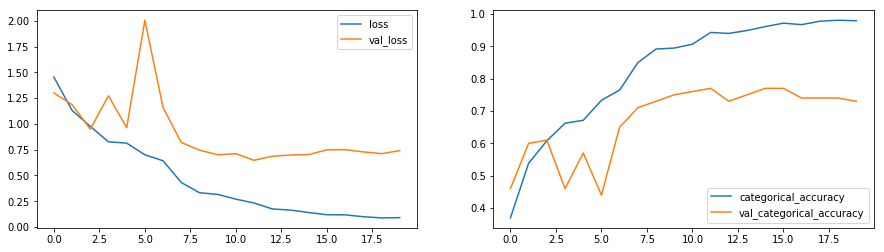

In [29]:
plot(histor11)

In [71]:
#### Model 12 Transfer Learning with GRU

In [20]:
from keras.applications import mobilenet

mobile_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class TL_GRU(ModelBuilder):
    
    def define_model(self,gru=64,dense=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobile_transfer,input_shape=(self.frame_sample,self.image_h,self.image_w,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 2s 0us/step


In [21]:
TL_gru =TL_GRU()
TL_gru.init_path(Project_folder)
TL_gru.init_image(image_h=120,image_w=120)
TL_gru.init_hyperparams(frame_sample=20,batch_size=10,num_epochs=20)
TL_gru_model=TL_gru.define_model(gru=128,dense=128,dropout=0.25)#change lstm=128 in next run 
TL_gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

In [33]:
print("Total Params:", TL_gru_model.count_params())
history12 = TL_gru.train_model(TL_gru_model)

Total Params: 3692869
Epoch 1/20
67/67 [==============================] - 63s 936ms/step - loss: 0.9831 - categorical_accuracy: 0.6293 - val_loss: 0.6212 - val_categorical_accuracy: 0.7000

Epoch 00001: val_loss improved from inf to 0.62122, saving model to model_init_2020-03-2820_39_16.698856/model-00001-0.97825-0.62896-0.62122-0.70000.h5
Epoch 2/20
67/67 [==============================] - 50s 749ms/step - loss: 0.5288 - categorical_accuracy: 0.8050 - val_loss: 0.5294 - val_categorical_accuracy: 0.7700

Epoch 00002: val_loss improved from 0.62122 to 0.52936, saving model to model_init_2020-03-2820_39_16.698856/model-00002-0.52707-0.80995-0.52936-0.77000.h5
Epoch 3/20
67/67 [==============================] - 50s 750ms/step - loss: 0.3782 - categorical_accuracy: 0.8533 - val_loss: 0.6381 - val_categorical_accuracy: 0.7200

Epoch 00003: val_loss did not improve from 0.52936
Epoch 4/20
67/67 [==============================] - 50s 750ms/step - loss: 0.4383 - categorical_accuracy: 0.8477 - 

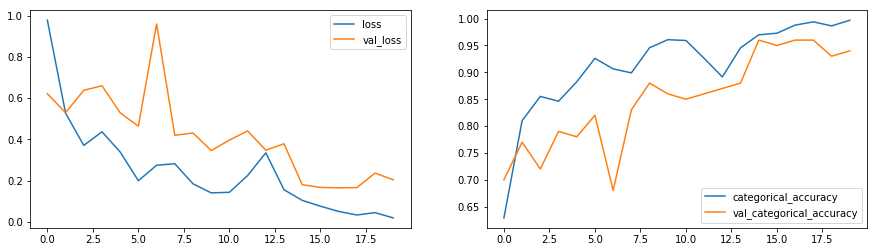

In [34]:
plot(history12)

## Finalizing the models and making prediction
* Model 4 with 1,762,613 parameters yields an accuracy of 85% validation data.
* Model 7 with Just 909,637 parameters is also a good candidate which gives us 82% of the validation data accuracy.
* While model 4 & 7 are 3DConv models the model with transfer learnings outperformes every model that we built.
* Model 12 with 3,692,869 parameters gives us a 96% of accuracy on validation dataset.


### Making prediction with model 4

In [33]:
from keras.models import load_model
from timeit import default_timer as timer
from datetime import timedelta


#loading the model
model = load_model('./model_init_2020-03-2816_35_23.533428/model-00028-0.28017-0.89894-0.57492-0.85000.h5')

val_generator1= conv3D8()
val_generator1.init_path(Project_folder)
val_generator1.init_image(image_h=120,image_w=120)
val_generator1.init_hyperparams(frame_sample=16,batch_size=1,num_epochs=1)

generate =val_generator1.generator(val_generator1.val_path,val_generator1.val_doc,augment=False)
batch_data, batch_labels=next(generate)


In [41]:
import numpy as np
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

start = timer()
print(model.predict(batch_data[:,:,:,:,:]))

end = timer()
print("model prediction time model 4: ", timedelta(seconds=end-start))

[[0.000088 0.000041 0.999795 0.000032 0.000043]]
model prediction time model 4:  0:00:00.049726


In [ ]:
# Model 4 gives us the classification with 99% confidance

### Making prediction with Model 12

In [35]:
from keras.models import load_model
from timeit import default_timer as timer
from datetime import timedelta


model = load_model('model_init_2020-03-2820_39_16.698856/model-00017-0.04990-0.98793-0.16461-0.96000.h5')

val_generator = TL_GRU()
val_generator.init_path(Project_folder)
val_generator.init_image(image_h=120,image_w=120)
val_generator.init_hyperparams(frame_sample=20,batch_size=1,num_epochs=1)

generate = val_generator.generator(val_generator.val_path,val_generator.val_doc,augment=False)
batch_data, batch_labels=next(generate)


In [40]:
import numpy as np
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

start = timer()
print(model.predict(batch_data[:,:,:,:,:]) ) 

end = timer()
print("\n model prediction time model 12: ", timedelta(seconds=end-start))

[[0.000088 0.000041 0.999795 0.000032 0.000043]]

 model prediction time model 12:  0:00:00.050639


In [ ]:
# Model 12 gives us the classification with 99% confidance